In [28]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [29]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

871


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,1b8060bdc5a3352981182100992d1c8bf288accb,yucky-nave,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,2.0,direct/excellent-format-few.txt,cq.txt,auto/direct.json,...,22.0,180,80.705556,49.888893,0,16.25,107.0,116.25,142,direct
1,ae3155e67a2ebcf7110be676007ce26b9b177156,ratty-loss,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,2.0,direct/format-few.txt,cq.txt,auto/direct.json,...,25.0,202,93.247525,48.622499,0,85.25,113.0,124.75,171,direct
2,6df4e7f03841c52772cfd061a555722d1d875ae3,ducky-bang,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,2.0,direct/format-few.txt,cq.txt,auto/direct.json,...,121.0,174,84.885057,52.431828,0,14.50,108.0,123.00,162,direct
3,59a5017312ec70618b3c7cc10183e3cc7c04f34b,sated-heck,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,2.0,direct/format-few.txt,cq.txt,auto/direct.json,...,110.0,172,77.703488,52.215135,0,9.00,106.0,118.00,149,direct
4,ebaa50320f703f4854c9541173c4da3668e832e5,risen-prob,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,1.5,direct/excellent-format-few.txt,cq.txt,auto/direct.json,...,21.0,86,11.093023,15.928242,3,4.00,5.0,10.75,123,direct


In [30]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [31]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df.head()

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,0.1,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,1,0.646667,0.739779,0.73,0.836478,...,100.0,80,52.575000,15.572432,26,43.00,49.0,62.0,98,ccot
1,0.1,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,2,0.633333,0.742517,0.71,0.831446,...,99.0,79,54.962025,18.533022,24,43.00,50.0,65.5,100,ccot
2,0.1,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,3,0.643333,0.744104,0.73,0.838430,...,99.0,79,55.531646,18.243253,27,43.00,50.0,67.5,100,ccot
3,0.5,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,1,0.620000,0.727099,0.70,0.816986,...,97.0,84,55.797619,16.554241,26,43.75,52.5,65.0,98,ccot
4,0.5,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,2,0.613333,0.725788,0.72,0.834653,...,89.0,85,54.741176,16.537226,24,44.00,50.0,65.0,99,ccot


In [32]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) != 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,params.run
77,cot,cot/excellent-format-thought.txt,cq.txt,auto/cot.json,0,2.0,"(1, 1, 2, 2, 3, 3)"
83,cot,cot/excellent-format-thought.txt,cq.txt,auto/cot.json,1,2.0,"(1, 2, 2, 3)"
113,cot,cot/format-thought.txt,cq.txt,auto/cot.json,0,2.0,"(1, 2, 2, 3, 3)"
119,cot,cot/format-thought.txt,cq.txt,auto/cot.json,1,2.0,"(1, 2, 3, 3)"


In [33]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [34]:
df['params.qa.system_prompt'].unique()

array(['ccot/excellent-format-thought', 'ccot/format-thought',
       'cot/excellent-format-thought', 'cot/format-thought',
       'cte/excellent-format-triplets-few', 'cte/format-triplets-few',
       'direct/excellent-format-few', 'direct/format-few'], dtype=object)

In [35]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
0,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,0.641111,0.742133,0.723333,0.835452,...,57.000000,99.333333,79.333333,54.356224,17.449569,25.666667,43.000000,49.666667,65.000000,99.333333
1,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.5,0.627778,0.731521,0.713333,0.826240,...,56.000000,93.666667,82.666667,54.314620,16.581218,24.666667,42.916667,50.500000,64.833333,97.666667
2,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.7,0.631111,0.734677,0.716667,0.819466,...,54.750000,95.666667,83.000000,53.941886,17.095895,24.666667,42.750000,50.000000,63.333333,98.000000
3,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,1.0,0.630000,0.734700,0.713333,0.826663,...,55.916667,94.000000,81.333333,53.716463,17.970605,21.000000,41.750000,49.833333,64.083333,99.000000
4,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,1.5,0.576667,0.691900,0.676667,0.790686,...,57.666667,100.000000,95.333333,58.816320,22.351162,24.000000,42.500000,53.333333,73.666667,118.333333


In [36]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
169,cte,cte/excellent-format-triplets-few,cq,auto/cte,6,0.5,0.698889,0.789375,0.760000,0.852405,...,51.250000,94.333333,62.333333,48.366701,15.021856,26.0,37.666667,45.333333,57.000000,98.000000
67,ccot,ccot/format-thought,cq,auto/ccot,9,0.5,0.678889,0.778162,0.746667,0.836723,...,52.583333,88.666667,66.666667,51.362789,16.337178,27.0,38.916667,47.500000,61.750000,97.333333
282,direct,direct/format-few,cq,auto/direct,9,0.1,0.683333,0.774700,0.766667,0.858582,...,7.000000,20.000000,69.666667,8.185645,7.719721,3.0,4.000000,5.000000,8.916667,47.666667
127,cot,cot/format-thought,cq,auto/cot,3,0.5,0.684444,0.772010,0.746667,0.837830,...,72.166667,179.000000,70.666667,74.609715,26.717363,23.0,58.666667,72.000000,87.250000,167.000000


## Visualizations

In [37]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["n_shot"].map(str)
    )

    return dataf


In [38]:
def plot_variance(dataf, x='temperature', y='f1', hue='prompt', technique=None, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    if technique:
        dataf = dataf[dataf['technique'] == technique]
    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, hue=hue, data=dataf, linewidth=2.5, legend=legend)
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [39]:
prepared_df = prepare_data(df)
zero_shot_mask = prepared_df["n_shot"] == 0
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt
0,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,1,0.646667,0.739779,ccot/excellent-format-thought | cq | 0
1,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,2,0.633333,0.742517,ccot/excellent-format-thought | cq | 0
2,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,3,0.643333,0.744104,ccot/excellent-format-thought | cq | 0
3,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.5,1,0.620000,0.727099,ccot/excellent-format-thought | cq | 0
4,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.5,2,0.613333,0.725788,ccot/excellent-format-thought | cq | 0
...,...,...,...,...,...,...,...,...,...,...
866,direct,direct/format-few,cq,auto/direct,9,1.5,2,0.660000,0.750121,direct/format-few | cq | 9
867,direct,direct/format-few,cq,auto/direct,9,1.5,3,0.623333,0.723799,direct/format-few | cq | 9
868,direct,direct/format-few,cq,auto/direct,9,2.0,1,0.363333,0.437498,direct/format-few | cq | 9
869,direct,direct/format-few,cq,auto/direct,9,2.0,2,0.386667,0.504954,direct/format-few | cq | 9


## Statistical Testing

In [41]:
def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

def one_way_anova_by_nshot(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    
    # Perform One-Way ANOVA at each n-shot
    nshot_values = dataf["n_shot"].unique()
    for nshot in nshot_values:
        _dataf = dataf[dataf["n_shot"] == nshot]
        grouped = _dataf.groupby("technique")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping n-shot {nshot}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for n-shot {nshot:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [42]:
def report(dataf, alpha=0.005):
    print("Prompt values")
    for prompt in dataf.prompt.unique():
        print("\t", prompt)
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # One-Way ANOVA by n-shot
    one_way_anova_by_nshot(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['prompt'], alpha=alpha)
    print(tukey)

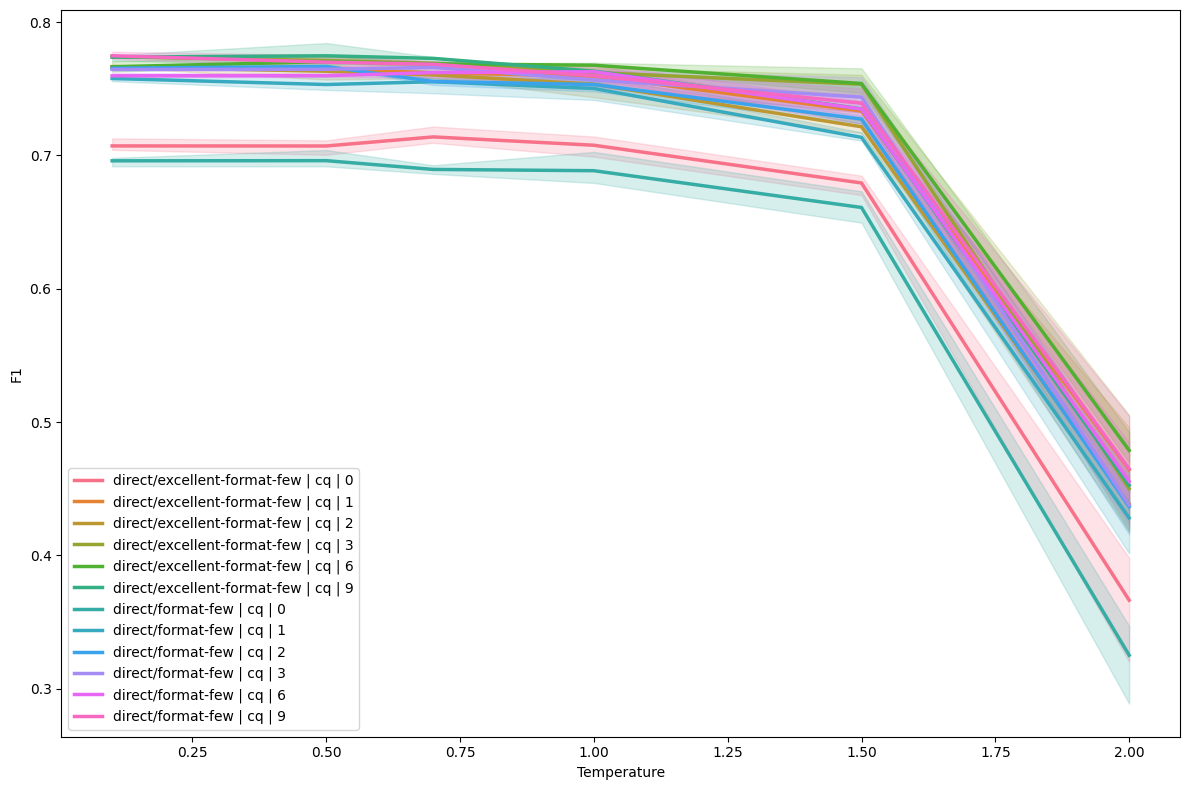

In [43]:
plot_variance(prepared_df, technique='direct', legend='brief')

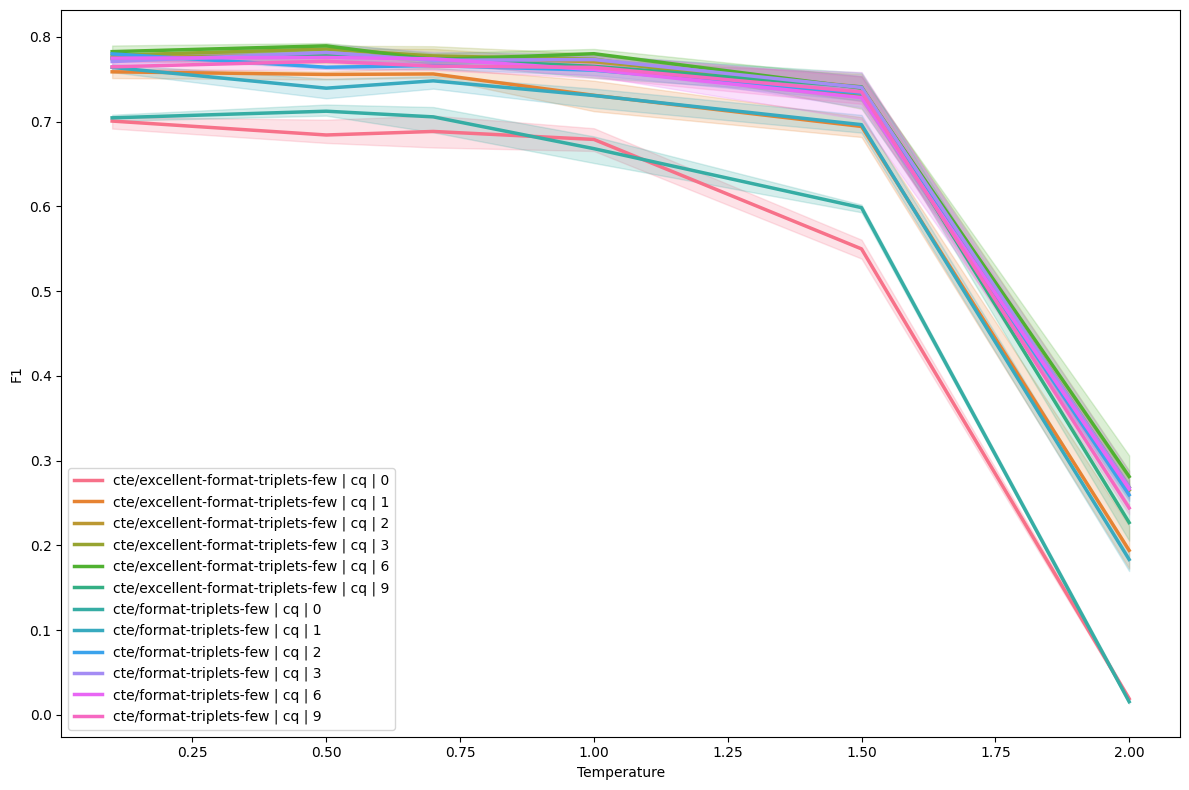

In [44]:
plot_variance(prepared_df, technique='cte', legend='brief')

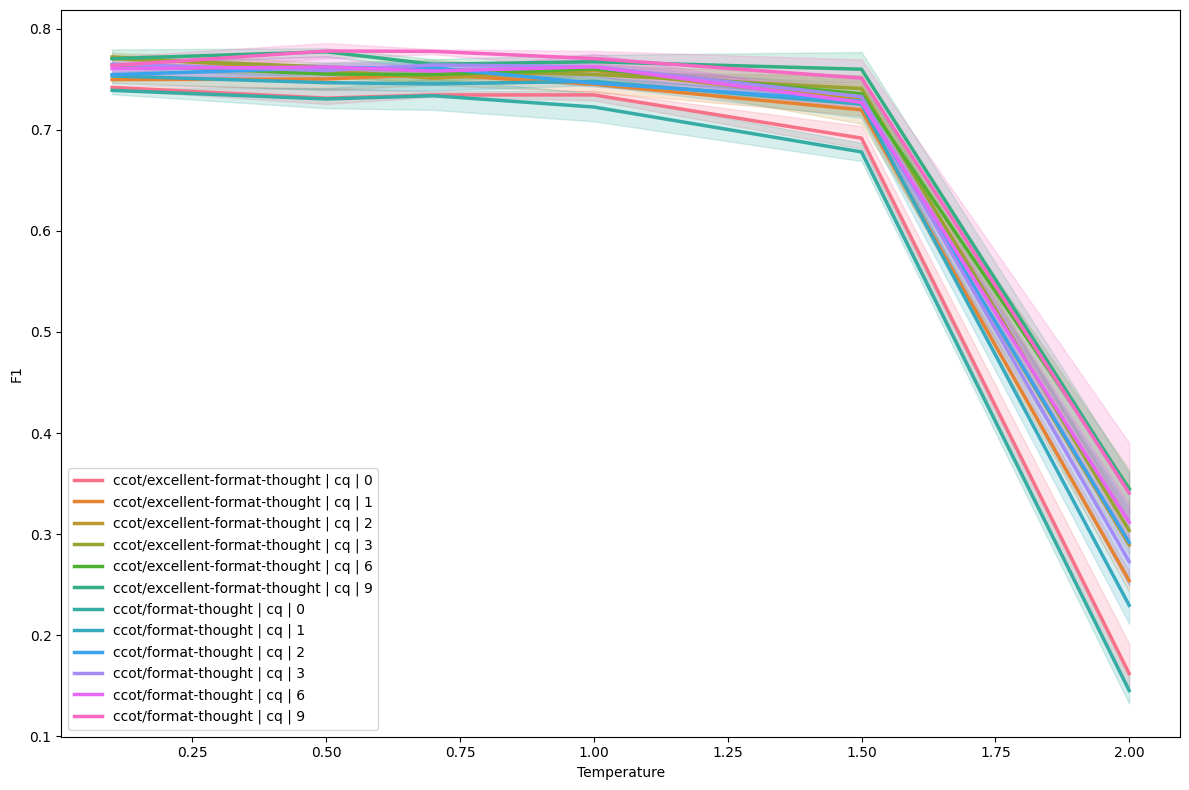

In [45]:
plot_variance(prepared_df, technique='ccot', legend='brief')

In [46]:
report(prepared_df[prepared_df['temperature'] == 0.1])

Prompt values
	 ccot/excellent-format-thought | cq | 0
	 ccot/excellent-format-thought | cq | 1
	 ccot/excellent-format-thought | cq | 2
	 ccot/excellent-format-thought | cq | 3
	 ccot/excellent-format-thought | cq | 6
	 ccot/excellent-format-thought | cq | 9
	 ccot/format-thought | cq | 0
	 ccot/format-thought | cq | 1
	 ccot/format-thought | cq | 2
	 ccot/format-thought | cq | 3
	 ccot/format-thought | cq | 6
	 ccot/format-thought | cq | 9
	 cot/excellent-format-thought | cq | 0
	 cot/excellent-format-thought | cq | 1
	 cot/excellent-format-thought | cq | 2
	 cot/excellent-format-thought | cq | 3
	 cot/excellent-format-thought | cq | 6
	 cot/excellent-format-thought | cq | 9
	 cot/format-thought | cq | 0
	 cot/format-thought | cq | 1
	 cot/format-thought | cq | 2
	 cot/format-thought | cq | 3
	 cot/format-thought | cq | 6
	 cot/format-thought | cq | 9
	 cte/excellent-format-triplets-few | cq | 0
	 cte/excellent-format-triplets-few | cq | 1
	 cte/excellent-format-triplets-few | cq | 2

                                    Multiple Comparison of Means - Tukey HSD, FWER=0.01                                    
                  group1                                     group2                   meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------------------------------------------------
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 1   0.0077    1.0 -0.4553 0.4708  False
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 2   0.0301    1.0 -0.4329 0.4932  False
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 3   0.0286    1.0 -0.4344 0.4916  False
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 6   0.0223    1.0 -0.4407 0.4853  False
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 9   0.0285    1.0 -0.4345 0.4916  False
    ccot

### All techniques

In [47]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_df = _data.loc[prompt_mask]
best_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt
198,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,1,0.650000,0.762843,ccot/format-thought | cq | 9
199,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,2,0.650000,0.756045,ccot/format-thought | cq | 9
200,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,3,0.660000,0.772530,ccot/format-thought | cq | 9
201,ccot,ccot/format-thought,cq,auto/ccot,9,0.5,1,0.680000,0.786074,ccot/format-thought | cq | 9
202,ccot,ccot/format-thought,cq,auto/ccot,9,0.5,2,0.686667,0.777405,ccot/format-thought | cq | 9
...,...,...,...,...,...,...,...,...,...,...
866,direct,direct/format-few,cq,auto/direct,9,1.5,2,0.660000,0.750121,direct/format-few | cq | 9
867,direct,direct/format-few,cq,auto/direct,9,1.5,3,0.623333,0.723799,direct/format-few | cq | 9
868,direct,direct/format-few,cq,auto/direct,9,2.0,1,0.363333,0.437498,direct/format-few | cq | 9
869,direct,direct/format-few,cq,auto/direct,9,2.0,2,0.386667,0.504954,direct/format-few | cq | 9


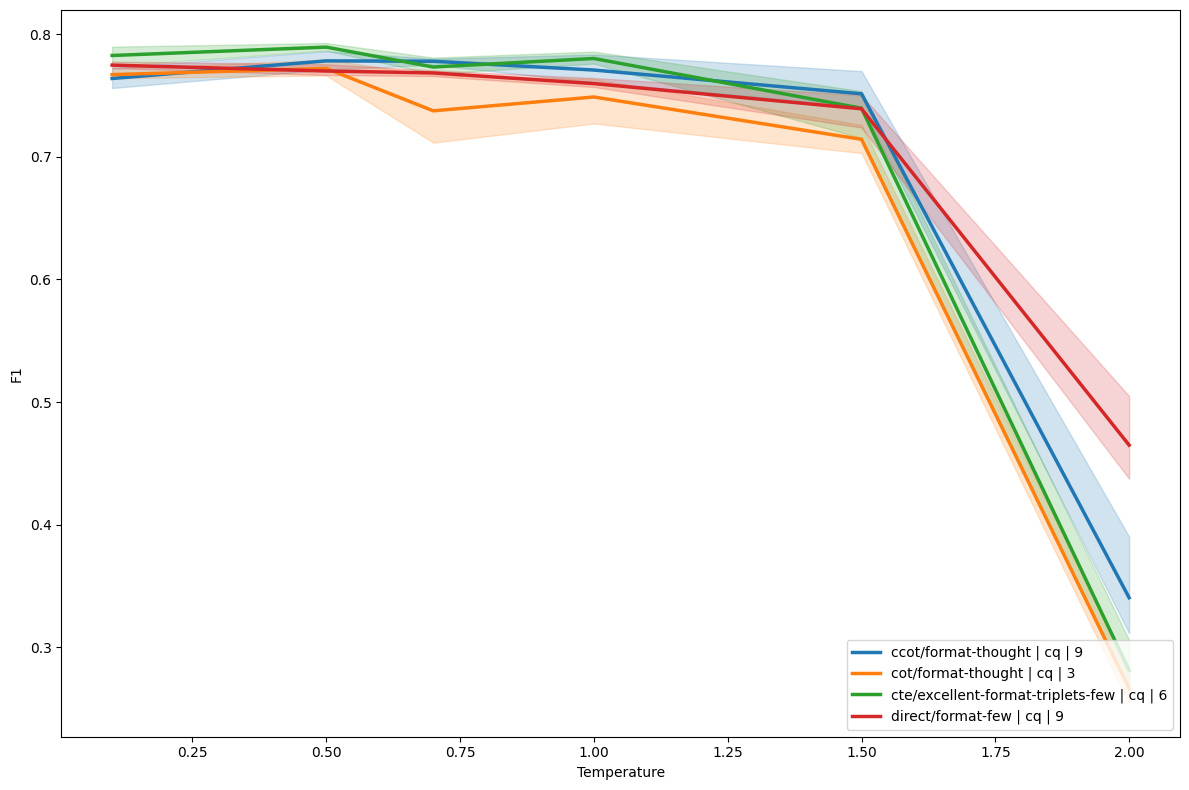

In [48]:
plot_variance(best_prepared_df, figsize=(12, 8), legend_loc='lower right')

In [49]:
report(best_prepared_df)

Prompt values
	 ccot/format-thought | cq | 9
	 cot/format-thought | cq | 3
	 cte/excellent-format-triplets-few | cq | 6
	 direct/format-few | cq | 9


Temperature values:  0.1, 0.5, 0.7, 1.0, 1.5, 2.0


One-Way ANOVA for Temperature 0.1:
F-statistic: 5.3545, p-value: 2.5740e-02
One-Way ANOVA for Temperature 0.5:
F-statistic: 6.4076, p-value: 1.6044e-02
One-Way ANOVA for Temperature 0.7:
F-statistic: 4.8073, p-value: 3.3686e-02
One-Way ANOVA for Temperature 1.0:
F-statistic: 4.1058, p-value: 4.8906e-02
One-Way ANOVA for Temperature 1.5:
F-statistic: 2.8640, p-value: 1.0404e-01
One-Way ANOVA for Temperature 2.0:
F-statistic: 25.6585, p-value: 1.8590e-04


One-Way ANOVA for n-shot 9.0:
F-statistic: 0.1093, p-value: 7.4293e-01
Skipping n-shot 3: Not enough groups to perform ANOVA
Skipping n-shot 6: Not enough groups to perform ANOVA


                                    Multiple Comparison of Means - Tukey HSD, FWER=0.01                                    
                  group1         

## Inspect

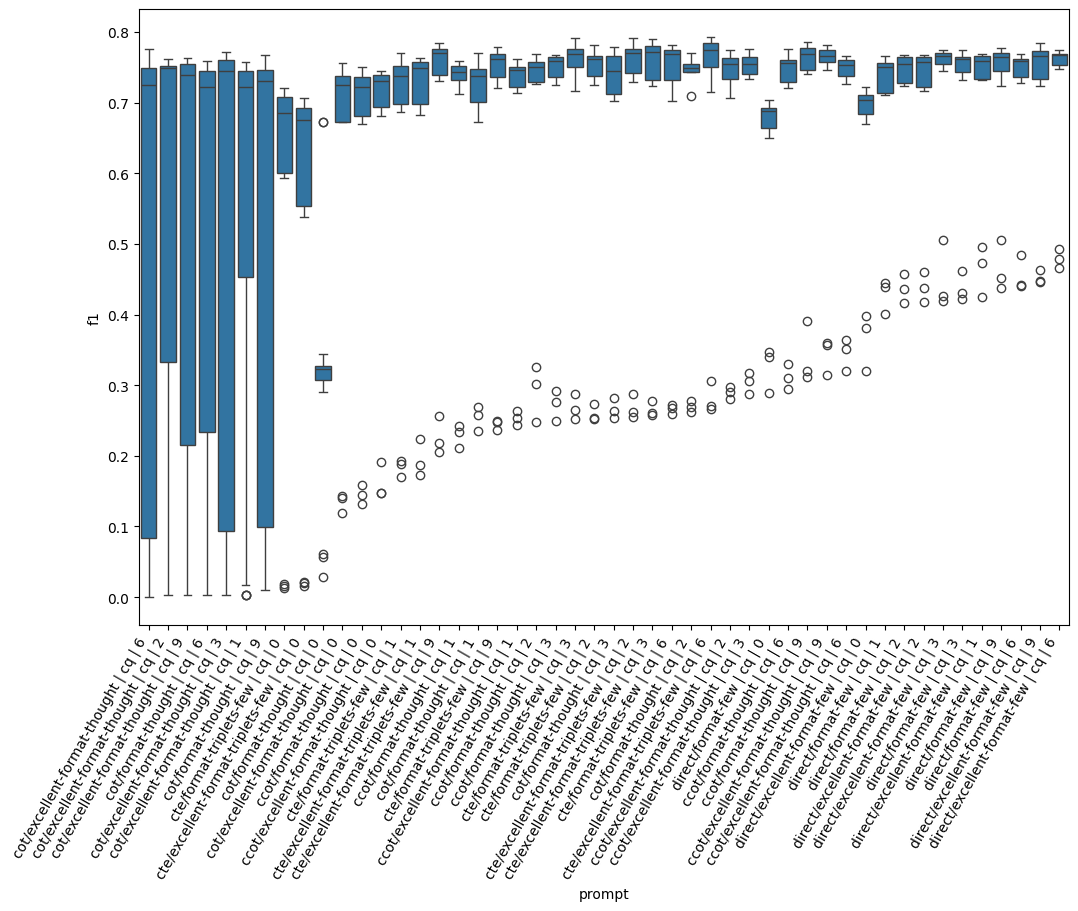

In [50]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.sort_values(by="f1"),
)
plt.xticks(rotation=60, ha="right");

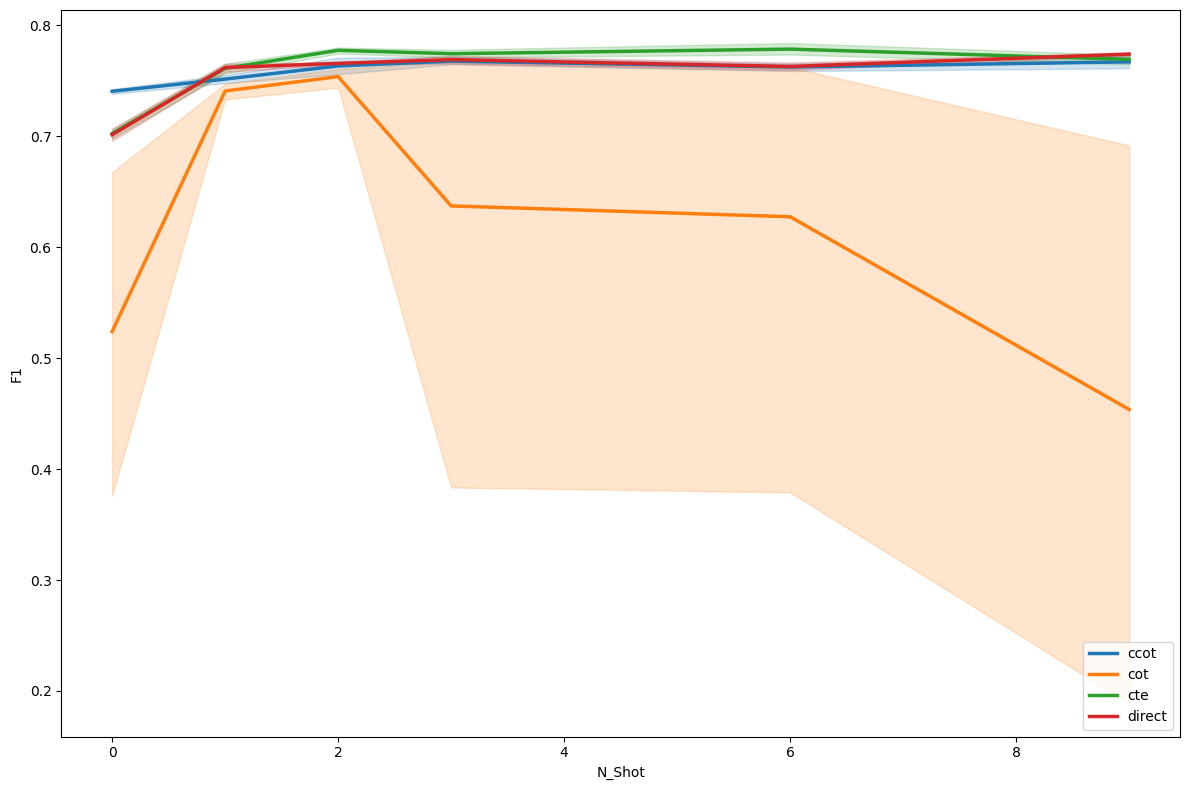

In [51]:
plot_variance(prepared_df[prepared_df['temperature'] == 0.1], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

In [52]:
prepared_df['temperature'].unique()

array([0.1, 0.5, 0.7, 1. , 1.5, 2. ])

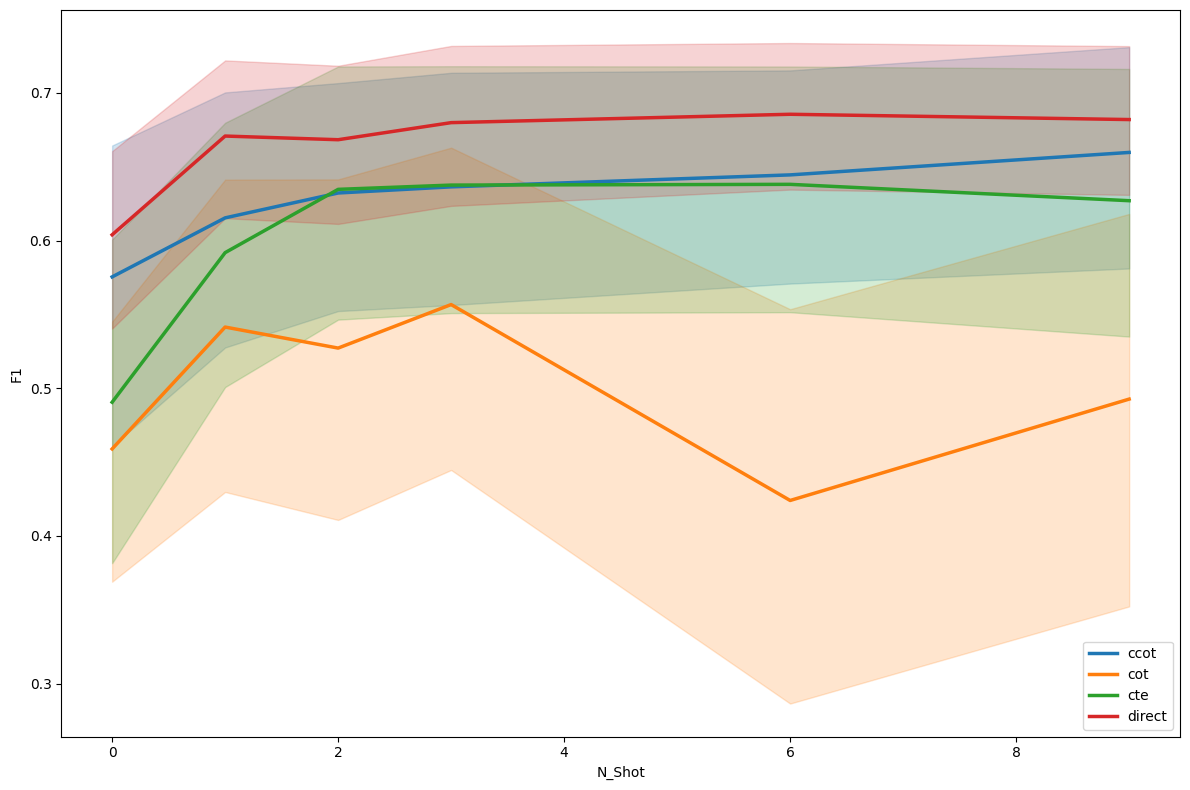

In [53]:
plot_variance(prepared_df[prepared_df['temperature'] > 0.6], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

In [54]:
df

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,0.1,ccot/excellent-format-thought,cq,auto/ccot,0,1,0.646667,0.739779,0.73,0.836478,...,100.0,80,52.575000,15.572432,26,43.00,49.0,62.00,98,ccot
1,0.1,ccot/excellent-format-thought,cq,auto/ccot,0,2,0.633333,0.742517,0.71,0.831446,...,99.0,79,54.962025,18.533022,24,43.00,50.0,65.50,100,ccot
2,0.1,ccot/excellent-format-thought,cq,auto/ccot,0,3,0.643333,0.744104,0.73,0.838430,...,99.0,79,55.531646,18.243253,27,43.00,50.0,67.50,100,ccot
3,0.5,ccot/excellent-format-thought,cq,auto/ccot,0,1,0.620000,0.727099,0.70,0.816986,...,97.0,84,55.797619,16.554241,26,43.75,52.5,65.00,98,ccot
4,0.5,ccot/excellent-format-thought,cq,auto/ccot,0,2,0.613333,0.725788,0.72,0.834653,...,89.0,85,54.741176,16.537226,24,44.00,50.0,65.00,99,ccot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,1.5,direct/format-few,cq,auto/direct,9,2,0.660000,0.750121,0.74,0.821894,...,83.0,79,11.291139,12.604590,0,4.00,6.0,11.50,63,direct
867,1.5,direct/format-few,cq,auto/direct,9,3,0.623333,0.723799,0.74,0.824560,...,14.0,86,16.860465,26.025853,3,4.00,6.0,15.75,137,direct
868,2.0,direct/format-few,cq,auto/direct,9,1,0.363333,0.437498,0.46,0.548087,...,11.0,176,84.068182,51.350848,0,18.25,104.0,121.00,165,direct
869,2.0,direct/format-few,cq,auto/direct,9,2,0.386667,0.504954,0.48,0.604317,...,79.0,154,79.577922,52.339987,3,10.00,103.0,118.00,167,direct
